In [2]:
import os
import xml.etree.ElementTree as ET
from collections import defaultdict
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.dates as mdates

# 设置字体类型
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def is_different_imageview(imageview1, imageview2):
    # 比较 imageview 的所有属性是否相同
    return imageview1.attrib != imageview2.attrib

def get_imageviews_from_xml(file_path):
    # 检查文件是否为空
    # print(f"解析文件: {file_path}")
    if os.path.getsize(file_path) == 0:
        return []  # 或者返回空列表 []
    # 解析 XML 文件并提取所有 ImageView 和 DrawerLayout 元素
    tree = ET.parse(file_path)
    root = tree.getroot()
    return root.findall(".//*[@class='android.widget.ImageView']") + root.findall(".//*[@class='androidx.drawerlayout.widget.DrawerLayout']")

def compare_imageviews(imageviews_file1, imageviews_file2):
    # 比较两个文件中的 ImageView 列表，找出新增或更新的元素
    updated_imageviews = []
    
    for imageview2 in imageviews_file2:
        is_new_or_updated = True
        for imageview1 in imageviews_file1:
            if not is_different_imageview(imageview1, imageview2):
                is_new_or_updated = False
                break
        if is_new_or_updated:
            updated_imageviews.append(imageview2)
    
    return updated_imageviews

import hashlib

def calculate_file_hash(file_path):
    """Calculate the SHA-256 hash of the file contents."""
    hasher = hashlib.sha256()
    with open(file_path, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def compare_imageviews_with_all_previous_hashes(current_file, previous_hashes):
    """Compare the hash of the current image view file with all previous hashes."""
    current_file_hash = calculate_file_hash(current_file)
    # Check if this hash matches any previous hash
    if current_file_hash in previous_hashes:
        return False  # It matches a previous one, so it's not considered new
    else:
        # If it's different from all, add the new hash to the set
        previous_hashes.add(current_file_hash)
        return True

def extract_timestamp_from_filename(file_name):
    date_str, time_str = file_name.split("_")[-2:]
    timestamp_str = date_str + "_" + time_str.replace(".xml", "")
    return datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")


def analyze_xml_folder_with_hash(folder_path):
    # Initialize hash dictionary and previous hashes set
    hash_dict = {}
    previous_hashes = set()  # Set to store all previous hashes
    table = pd.DataFrame(columns=['App', 'Total usage time (seconds)', 'Total ImageView count', 'App image view throughput'])

    xml_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".xml")])
    
    if len(xml_files) < 2:
        print("至少需要两个 XML 文件来进行对比")
        return
    
    # Calculate hashes for all XML files and store them
    for xml_file in xml_files:
        file_hash = calculate_file_hash(xml_file)
        hash_dict[xml_file] = file_hash

    app_imageview_data = defaultdict(list)
    app_imageview_count = defaultdict(lambda: defaultdict(int))
    app_usage_time = defaultdict(int)
    
    previous_imageviews = get_imageviews_from_xml(xml_files[0])
    previous_timestamp = extract_timestamp_from_filename(os.path.basename(xml_files[0]))

    # Store the hash of the first file
    previous_hashes.add(hash_dict[xml_files[0]])

    for view in previous_imageviews:
        resource_id = view.attrib.get('resource-id', '')
        if resource_id:
            app_name = resource_id.split('/')[0]
            app_imageview_data[app_name].append((previous_timestamp, len(previous_imageviews)))

    for i in range(1, len(xml_files)):
        current_imageviews = get_imageviews_from_xml(xml_files[i])
        current_timestamp = extract_timestamp_from_filename(os.path.basename(xml_files[i]))
        time_diff = (current_timestamp - previous_timestamp).total_seconds()

        if time_diff > 20:
            previous_imageviews = current_imageviews
            previous_timestamp = current_timestamp
            continue
        
        # Compare current file hash with all previous hashes
        if compare_imageviews_with_all_previous_hashes(xml_files[i], previous_hashes):
            updated_imageviews = compare_imageviews(previous_imageviews, current_imageviews)
            for view in updated_imageviews:
                resource_id = view.attrib.get('resource-id', '')
                if resource_id:
                    app_name = resource_id.split('/')[0]
                    app_imageview_count[app_name]['count'] += 1
                    app_usage_time[app_name] += time_diff
                    app_imageview_data[app_name].append((current_timestamp, 1))

        previous_imageviews = current_imageviews
        previous_timestamp = current_timestamp
        
    # Output results
    for app, usage_data in app_imageview_count.items():
        usage_time = app_usage_time[app]
        print(f"App: {app}")
        print(f"Total usage time (seconds): {usage_time}")
        print(f"Total ImageView count: {usage_data['count']}")
        print(f"App image view throughput: {usage_data['count'] / (usage_time / 60):.2f} views/minute")
        print("-" * 50)
        new_row = pd.DataFrame({'App': [app], 
                        'Total usage time (seconds)': [usage_time], 
                        'Total ImageView count': [usage_data['count']], 
                        'App image view throughput': [usage_data['count'] / (usage_time / 60)]})
        table = pd.concat([table, new_row], ignore_index=True)

    # Save the results to a CSV file
    output_csv_path = f'{folder_path}_summary.csv'
    table.to_csv(output_csv_path, index=False)
    print(f"Summary table saved to {output_csv_path}")

    return app_imageview_data, table

def analyze_xml_folder(folder_path):
    table = pd.DataFrame(columns=['App', 'Total usage time (seconds)', 'Total ImageView count', 'App image view throughtput'])
    # 获取文件夹中所有 XML 文件，并按文件名排序
    xml_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".xml")])
    
    if len(xml_files) < 2:
        print("至少需要两个 XML 文件来进行对比")
        return
    
    app_imageview_data = defaultdict(list)
    
    # 保存总的更新或新增的 ImageView 元素，按 app 分类
    app_imageview_count = defaultdict(lambda: defaultdict(int))
    app_usage_time = defaultdict(int)  # 用于存储每个 app 的使用时间
    
    # 提取第一个文件中的 ImageView 作为基准
    previous_imageviews = get_imageviews_from_xml(xml_files[0])
    previous_timestamp = extract_timestamp_from_filename(os.path.basename(xml_files[0]))

    # 打印previous_imageviews的长度
    # print(f"Previous image views: {len(previous_imageviews)}")

    # 需要把第一个的imageview作为第一个
    for view in previous_imageviews:
        resource_id = view.attrib.get('resource-id', '')
        if resource_id:
            app_name = resource_id.split('/')[0]  # 前缀作为 app_name
            app_imageview_data[app_name].append((previous_timestamp, len(previous_imageviews)))
    
    updated_imageviews = previous_imageviews
    
    # print(f"Updated image views: {len(updated_imageviews)}")

    # 依次比较相邻的两个文件
    for i in range(1, len(xml_files)):
        current_imageviews = get_imageviews_from_xml(xml_files[i])
        current_timestamp = extract_timestamp_from_filename(os.path.basename(xml_files[i]))
        
        #打印current_imageviews的长度
        # print(f"Current image views: {len(current_imageviews)}")

        # 计算当前文件和前一个文件之间的时间差（秒）
        time_diff = (current_timestamp - previous_timestamp).total_seconds()

        # print(f"Time diff: {time_diff}")
        
        # 忽略超过 10 秒时间差的xml文件，记录为idle
        if time_diff > 20:
            # print("skipping idle slot from {} to {}. Time difference is {}".format(previous_timestamp, current_timestamp, time_diff))
            previous_imageviews = current_imageviews
            previous_timestamp = current_timestamp
            continue
        
        updated_imageviews = compare_imageviews(previous_imageviews, current_imageviews)

        # print(f"Updated image views: {len(updated_imageviews)}")
        
        # 统计 resource-id 按 / 之前的部分作为 app_name 分类
        for view in updated_imageviews:
            resource_id = view.attrib.get('resource-id', '')
            if resource_id:
                app_name = resource_id.split('/')[0]  # 前缀作为 app_name
                app_imageview_count[app_name]['count'] += 1
                app_usage_time[app_name] += time_diff
                app_imageview_data[app_name].append((current_timestamp, 1))
        
        # 更新基准为当前文件的 imageview 列表和时间戳
        previous_imageviews = current_imageviews
        previous_timestamp = current_timestamp
    
    # 输出每个 app 在时间段内的使用时间和 ImageView 产生数量
    for app, usage_data in app_imageview_count.items():
        usage_time = app_usage_time[app]
        print(f"App: {app}")
        print(f"Total usage time (seconds): {usage_time}")
        print(f"Total ImageView count: {usage_data['count']}")
        print(f"App image view throughtput: {usage_data['count'] / (usage_time / 60):.2f} views/minute")
        print("-" * 50)
        new_row = pd.DataFrame({'App': [app], 
                        'Total usage time (seconds)': [usage_time], 
                        'Total ImageView count': [usage_data['count']], 
                        'App image view throughtput': [usage_data['count'] / (usage_time / 60)]})
        table = pd.concat([table, new_row], ignore_index=True)
        
    return app_imageview_data, table

def draw_xml_folder(app_imageview_data, folder_path, app_categories, k=10):
    # 定义类别颜色和样式
    category_styles = {
        "Communication & Social": {"color": "blue", "marker": "o", "linestyle": "-", "edgecolor": "black"},
        "Entertainment & Media": {"color": "red", "marker": "s", "linestyle": "-", "edgecolor": "black"},
        "Productivity & Utilities": {"color": "green", "marker": "^", "linestyle": "-.", "edgecolor": "black"},
        "Shopping & Finance": {"color": "purple", "marker": "d", "linestyle": "-", "edgecolor": "black"},
        "Health, Travel & Lifestyle": {"color": "orange", "marker": "v", "linestyle": "-", "edgecolor": "black"},
        "Others": {"color": "gray", "marker": "x", "linestyle": "-", "edgecolor": "black"}
    }

    # 选择 ImageView 数量最多的前 10 个应用
    top_apps = sorted(app_imageview_data.items(), key=lambda x: len(x[1]), reverse=True)[:k]
    
    # 绘制曲线
    plt.figure(figsize=(10, 4))
    
    category_counts = defaultdict(list)  # 用于存储每个类别的 counts
    plotted_categories = set()  # 用于追踪已经绘制的类别图例
    
    # 对每个 app 进行处理
    for app_name, data in top_apps:
        # 找到 app 所属类别
        category = "Others"
        for cat_name, apps in app_categories.items():
            if app_name in apps:
                category = cat_name
                break
        
        # 使用字典来合并相同分钟的 counts
        minute_counts = defaultdict(int)
        
        for time, count in data:
            # 将时间戳转换为分钟粒度
            minute = time.replace(second=0)
            # 将相同分钟内的 counts 合并
            minute_counts[minute] += count
        for time, count in minute_counts.items():
            if count > 500:  # 过滤掉异常值
                minute_counts[time] = 10
        
        # 将处理后的时间和 counts 列表化
        times = list(minute_counts.keys())
        counts = list(minute_counts.values())

        # 绘制散点图
        style = category_styles[category]
        
        # 检查该类别是否已经绘制过图例
        if category not in plotted_categories:
            plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"], 
                        edgecolor=style["edgecolor"], linestyle=style["linestyle"])
            plotted_categories.add(category)
        else:
            plt.scatter(times, counts, color=style["color"], marker=style["marker"], 
                        edgecolor=style["edgecolor"], linestyle=style["linestyle"])
        
        
        # 将 counts 添加到对应类别的列表中
        category_counts[category].extend(counts)
        
        print(f"App: {app_name}: average count per minute: {sum(counts) / len(counts):.2f}")

    # 输出每个类别的 average count per minute
    for category, counts in category_counts.items():
        if counts:
            avg_count = sum(counts) / len(counts)
            print(f"Category: {category}: average count per minute: {avg_count:.2f}")
    
    # 设置图例、标签和格式化
    # plt.xlabel("Time (Date & Hour)", fontsize=15)
    plt.ylabel("# of viewed images / minute", fontsize=15)
    plt.legend(title="Categoried Apps", ncol=3, borderaxespad=0., fontsize=12.5)
    
    # 设置横坐标格式为日期和小时
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # 自动标记时间
    plt.xticks(rotation=45, fontsize=15)
    
    plt.tight_layout()
    
    # plt.title(f"User: {folder_path.split('/')[-1]}")
    user = folder_path.split('/')[-1]
    plt.savefig(f'../figs/trace/top10-{user}-with-hash.pdf')
    
    # 显示图表
    plt.show()

    return top_apps, times, counts


In [3]:
app_categories = {
    "Communication & Social": [
        "com.tencent.mm:id",  # 微信
        "com.tencent.qqmusic:id",  # QQ音乐
        "com.tencent.wework:id",  # 企业微信
        "com.tencent.weworklocal:id",  # 企业微信本地
        "com.tencent.mobileqq:id",  # QQ
        "com.tencent.mobileqq.profilecard_feature_impl:id",  # QQ 资料卡
        "cn.byr.bbs.app:id",  # 北邮人BBS
        "com.android.contacts:id",  # 联系人
        "com.android.incallui:id"  # 电话
    ],
    "Entertainment & Media": [
        "com.baidu.netdisk:id",  # 百度网盘
        "com.baidu.tieba:id",  # 百度贴吧
        "tv.danmaku.bili:id",  # 哔哩哔哩
        "com.xingin.xhs:id",  # 小红书
        "com.zhihu.android:id",  # 知乎
        "com.ss.android.ugc.aweme:id",  # 抖音
        "com.netease.cloudmusic:id",  # 网易云音乐
        "com.duowan.kiwi:id",  # 虎牙直播
        "com.shanbay.sentence:id",  # 扇贝单词
        "com.picacomic.fregata:id"  # 哔咔漫画
        "com.android.camera:id",  # 相机
        "com.miui.gallery:id",  # 小米图库
        "com.oplus.camera:id",  # 相机
    ],
    "Productivity & Utilities": [
        "com.android.browser:id",  # 安卓浏览器
        "com.android.deskclock:id",  # 时钟
        "com.termux:id",  # Termux
        "com.google.android.documentsui:id",  # Google 文件管理
        "com.kingsoft:id",  # 金山办公
        "com.coloros.filemanager:id",  # 文件管理器
        "com.android.settings:id",  # 设置
        "com.coloros.note:id",  # 便签
        "com.coloros.weather2:id",  # 天气
        "com.oplus.securitypermission:id",  # 安全权限
        "com.oplus.ota:id",  # 系统更新
        "com.coloros.alarmclock:id",  # 闹钟
        "com.UCMobile:id",  # UC浏览器
        "com.miui.aod:id",  # 小米息屏显示
        "com.miui.voiceassist:id",  # 小米语音助手
        "com.android.fileexplorer:id",  # 文件管理器
        "com.miui.weather2:id",  # 小米天气
        "com.miui.notes:id",  # 小米便签
        "com.oplus.battery:id",  # 电池
        "com.heytap.quicksearchbox:id",  # 快速搜索
        "com.heytap.browser:id",  # 浏览器
        "com.coloros.calendar:id",  # 日历
        "com.coloros.colordirectservice:id",  # 直达服务
        "com.larus.nova:id",  # Nova 启动器
        "com.microsoft.emmx:id",  # Edge 浏览器
        "com.digibites.accubattery:id"  # AccuBattery
        "miui.systemui.plugin:id",  # 系统插件
        "com.android.settings:id"  # 设置
        "com.scenix.mlearning:id",  # Scenix 学习
    ],
    "Shopping & Finance": [
        # "com.android.systemui:id",  # 系统界面
        # "com.miui.home:id",  # 小米桌面
        "com.jd.lib.search.feature:id",  # 京东搜索
        "com.alipay.mobile.antui:id",  # 支付宝 AntUI
        "com.alipay.android.phone.openplatform:id",  # 支付宝开放平台
        "com.alipay.android.tablauncher:id",  # 支付宝桌面
        "com.alipay.mobile.homemsg:id",  # 支付宝消息中心
        "com.alipay.android.phone.mobilecommon.biometric:id",  # 支付宝生物识别
        "com.alipay.android.phone.messageboxstatic:id",  # 支付宝消息箱
        "com.alipay.android.phone.businesscommon.globalsearch:id",  # 支付宝全球搜索
        "com.alipay.mobile.rapidsurvey:id",  # 支付宝快调
        "com.alipay.android.phone.wealth.home:id",  # 支付宝财富
        "com.taobao.taobao:id",  # 淘宝
        "com.taobao.idlefish:id",  # 闲鱼
        "com.jingdong.app.mall:id",  # 京东商城
        "com.jd.lib.ordercenter.feature:id",  # 京东订单中心
        "com.jd.lib.productdetail.feature:id",  # 京东商品详情
        "com.jd.lib.cart.feature:id",  # 京东购物车
        "com.jd.lib.settlement.feature:id",  # 京东结算中心
        "com.psbc.mportal:id",  # 邮储银行
        "cmb.pb:id",  # 招商银行
        "com.wm.dmall:id",  # 美团小象生鲜
        "com.taobao.trip:id",  # 淘宝旅行
        "com.taobao.taobao.ratefeature:id"  # 淘宝评价
        "com.chinamworld.bocmbci:id",  # 中国银行
    ],
    "Health, Travel & Lifestyle": [
        "com.baidu.BaiduMap:id",  # 百度地图
        "com.autonavi.minimap:id",  # 高德地图
        "ctrip.android.view:id",  # 携程
        "com.android.mms:id",  # 短信
        "com.android.calendar:id",  # 日历
        "com.miui.screenshot:id",  # 小米截屏
        "com.mi.health:id",  # 小米健康
        "com.rytong.airchina:id",  # 中国国际航空
        "com.umetrip.android.msky.app:id",  # 航旅纵横
        "TCAtrainFirst_SpecialTrip_exposure",  # 特别行程
        "me.ele:id",  # 饿了么
        "com.sankuai.meituan:id",  # 美团
        "com.sankuai.meituan.takeoutnew:id",  # 美团外卖
        "com.wudaokou.hippo:id",  # 五道口河马
        "com.csair.mbp:id",  # 南方航空
        "com.Qunar:id",  # 去哪儿
        "com.huawei.health:id"  # 华为健康
    ]
}

../data/android/xml-xwk
App: com.termux:id
Total usage time (seconds): 4.0
Total ImageView count: 1
App image view throughput: 15.00 views/minute
--------------------------------------------------
App: com.miui.home:id
Total usage time (seconds): 12989.0
Total ImageView count: 2028
App image view throughput: 9.37 views/minute
--------------------------------------------------
App: android:id
Total usage time (seconds): 107.0
Total ImageView count: 19
App image view throughput: 10.65 views/minute
--------------------------------------------------
App: com.miui.securitycenter:id
Total usage time (seconds): 40.0
Total ImageView count: 5
App image view throughput: 7.50 views/minute
--------------------------------------------------
App: com.android.systemui:id
Total usage time (seconds): 27499.0
Total ImageView count: 3838
App image view throughput: 8.37 views/minute
--------------------------------------------------
App: com.tencent.mobileqq:id
Total usage time (seconds): 43279.0
Total Im

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_72866/1773770347.py:285: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_72866/1773770347.py:289: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


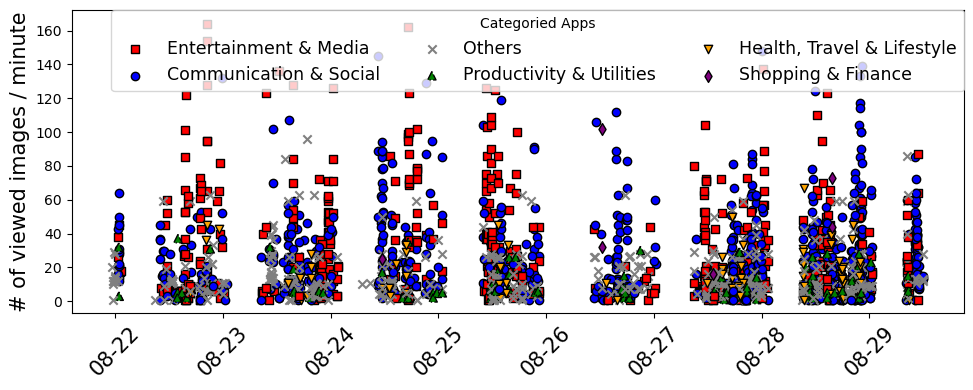

In [4]:
app_data = {}
# 运行脚本，指定 XML 文件夹路径
folder_paths = ['../data/android/xml-cyz',
                '../data/android/xml-wyz', 
                '../data/android/xml-zzl',
                '../data/android/xml-yc',
                '../data/android/xml-xwk',
                '../data/android/xml',
                '../data/android/xml-lhy',
                '../data/android/xml-dyf'][4:5]
for folder_path in folder_paths:
    print(folder_path)
    app_imageview_data, app_data[folder_path] = analyze_xml_folder_with_hash(folder_path)
    # Convert the defaultdict to a DataFrame if necessary
    if isinstance(app_data[folder_path], defaultdict):
        app_data[folder_path] = pd.DataFrame.from_dict(app_data[folder_path], orient='index').reset_index()
    draw_xml_folder(app_imageview_data, folder_path, app_categories, 40)
    app_data[folder_path] = app_data[folder_path].sort_values(by='Total ImageView count', ascending=False)
    app_data[folder_path].to_csv(f'../data/android/{folder_path.split("/")[-1]}_sorted.csv', index=False)

App: com.baidu.netdisk:id: average count per minute: 9.68
App: com.tencent.mm:id: average count per minute: 30.41
App: com.baidu.tieba:id: average count per minute: 46.32
App: tv.danmaku.bili:id: average count per minute: 33.42
App: com.tencent.mobileqq:id: average count per minute: 24.22
App: com.android.systemui:id: average count per minute: 15.67
App: com.miui.home:id: average count per minute: 20.48
App: com.android.browser:id: average count per minute: 9.70
App: com.zhihu.android:id: average count per minute: 33.24
App: com.sankuai.meituan:id: average count per minute: 14.03
App: com.ss.android.lark:id: average count per minute: 23.00
App: com.android.calendar:id: average count per minute: 47.29
App: com.autonavi.minimap:id: average count per minute: 13.30
App: com.jd.lib.search.feature:id: average count per minute: 55.20
App: miui.systemui.plugin:id: average count per minute: 4.73
App: ctrip.android.view:id: average count per minute: 14.64
App: com.android.deskclock:id: average c

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_69473/1773770347.py:285: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_69473/1773770347.py:289: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


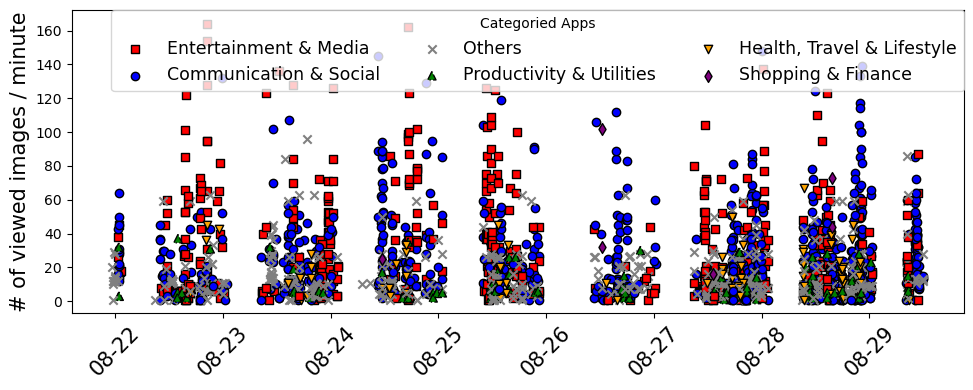

([('com.baidu.netdisk:id',
   [(datetime.datetime(2024, 8, 22, 10, 12, 45), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 45), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datet

In [24]:
draw_xml_folder(app_imageview_data, folder_path, app_categories, 40)

../data/android/xml
App: com.tencent.mm:id
Total usage time (seconds): 56191.0
Total ImageView count: 9179
App image view throughtput: 9.80 views/minute
--------------------------------------------------
App: com.termux:id
Total usage time (seconds): 243.0
Total ImageView count: 37
App image view throughtput: 9.14 views/minute
--------------------------------------------------
App: com.iflytek.inputmethod.miui:id
Total usage time (seconds): 15.0
Total ImageView count: 3
App image view throughtput: 12.00 views/minute
--------------------------------------------------
App: com.miui.home:id
Total usage time (seconds): 21653.0
Total ImageView count: 3624
App image view throughtput: 10.04 views/minute
--------------------------------------------------
App: com.miui.player:id
Total usage time (seconds): 865.0
Total ImageView count: 141
App image view throughtput: 9.78 views/minute
--------------------------------------------------
App: com.mi.health:id
Total usage time (seconds): 870.0
Total

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:270: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


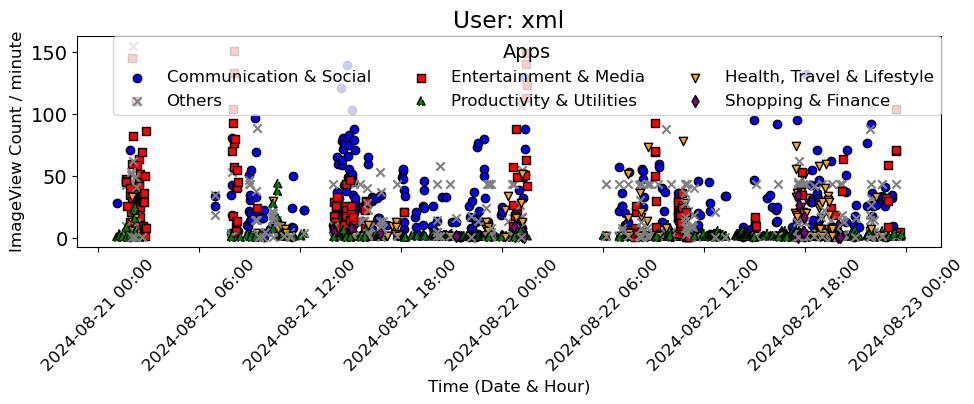

../data/android/xml-lhy
App: com.miui.home:id
Total usage time (seconds): 1168.0
Total ImageView count: 254
App image view throughtput: 13.05 views/minute
--------------------------------------------------
App: com.termux:id
Total usage time (seconds): 29.0
Total ImageView count: 3
App image view throughtput: 6.21 views/minute
--------------------------------------------------
App: com.tencent.mm:id
Total usage time (seconds): 65.0
Total ImageView count: 13
App image view throughtput: 12.00 views/minute
--------------------------------------------------
App: miui:id
Total usage time (seconds): 4.0
Total ImageView count: 1
App image view throughtput: 15.00 views/minute
--------------------------------------------------
App: com.android.phone:id
Total usage time (seconds): 32.0
Total ImageView count: 8
App image view throughtput: 15.00 views/minute
--------------------------------------------------
App: com.sina.weibo:id
Total usage time (seconds): 755.0
Total ImageView count: 125
App im

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:270: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


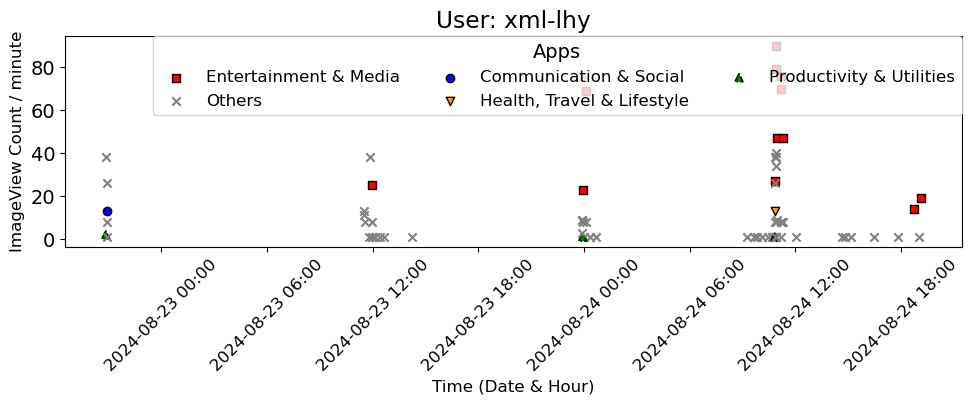

../data/android/xml-dyf
App: android:id
Total usage time (seconds): 703.0
Total ImageView count: 56
App image view throughtput: 4.78 views/minute
--------------------------------------------------
App: com.android.systemui:id
Total usage time (seconds): 150.0
Total ImageView count: 10
App image view throughtput: 4.00 views/minute
--------------------------------------------------
App: com.sec.android.app.myfiles:id
Total usage time (seconds): 1001.0
Total ImageView count: 112
App image view throughtput: 6.71 views/minute
--------------------------------------------------
App: com.termux:id
Total usage time (seconds): 67.0
Total ImageView count: 11
App image view throughtput: 9.85 views/minute
--------------------------------------------------
App: com.xingin.xhs:id
Total usage time (seconds): 4325.0
Total ImageView count: 788
App image view throughtput: 10.93 views/minute
--------------------------------------------------
App: com.samsung.android.app.aodservice:id
Total usage time (sec

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:270: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/4059555103.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


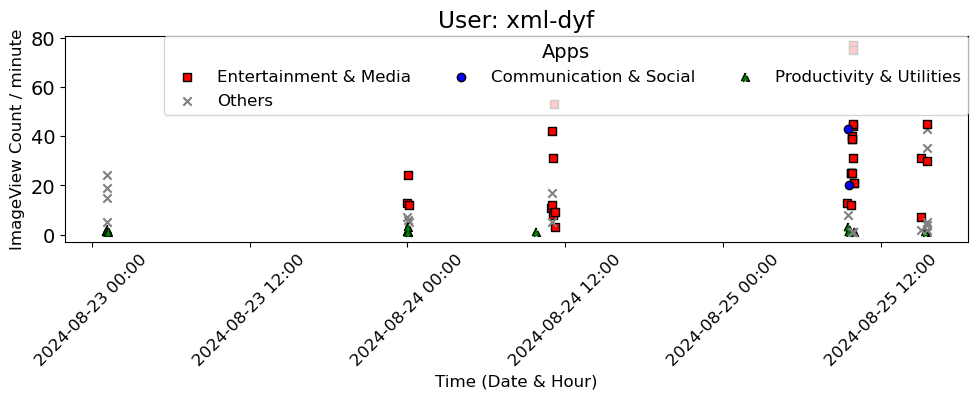

In [44]:
app_data = {}
# 运行脚本，指定 XML 文件夹路径
folder_paths = ['../data/android/xml-cyz',
                '../data/android/xml-wyz', 
                '../data/android/xml-zzl',
                '../data/android/xml-yc',
                '../data/android/xml-xwk',
                '../data/android/xml',
                '../data/android/xml-lhy',
                '../data/android/xml-dyf'][-3:]
for folder_path in folder_paths:
    print(folder_path)
    app_imageview_data, app_data[folder_path] = analyze_xml_folder(folder_path)
    # Convert the defaultdict to a DataFrame if necessary
    if isinstance(app_data[folder_path], defaultdict):
        app_data[folder_path] = pd.DataFrame.from_dict(app_data[folder_path], orient='index').reset_index()
    draw_xml_folder(app_imageview_data, folder_path, app_categories, 40)
    app_data[folder_path] = app_data[folder_path].sort_values(by='Total ImageView count', ascending=False)
    app_data[folder_path].to_csv(f'../data/android/{folder_path.split("/")[-1]}_sorted.csv', index=False)

In [40]:
app_imageview_data

defaultdict(list,
            {'com.termux:id': [(datetime.datetime(2024, 8, 21, 1, 6, 51), 1),
              (datetime.datetime(2024, 8, 21, 1, 15, 9), 1),
              (datetime.datetime(2024, 8, 21, 1, 15, 42), 1),
              (datetime.datetime(2024, 8, 21, 1, 15, 57), 1),
              (datetime.datetime(2024, 8, 21, 1, 16, 1), 1),
              (datetime.datetime(2024, 8, 21, 1, 16, 37), 1),
              (datetime.datetime(2024, 8, 21, 1, 25, 19), 1),
              (datetime.datetime(2024, 8, 21, 1, 41, 44), 1),
              (datetime.datetime(2024, 8, 21, 1, 53, 35), 1),
              (datetime.datetime(2024, 8, 21, 1, 53, 42), 1),
              (datetime.datetime(2024, 8, 21, 2, 7, 18), 1),
              (datetime.datetime(2024, 8, 21, 2, 27, 41), 1),
              (datetime.datetime(2024, 8, 21, 7, 55, 28), 1),
              (datetime.datetime(2024, 8, 21, 8, 26, 55), 1),
              (datetime.datetime(2024, 8, 21, 9, 3, 43), 1),
              (datetime.datetime(2024, 8

App: com.baidu.netdisk:id: average count per minute: 9.96
App: com.baidu.tieba:id: average count per minute: 48.33
App: com.tencent.mm:id: average count per minute: 29.24
App: tv.danmaku.bili:id: average count per minute: 37.20
App: com.tencent.mobileqq:id: average count per minute: 25.18
App: com.android.systemui:id: average count per minute: 15.63
App: com.miui.home:id: average count per minute: 25.68
App: com.android.browser:id: average count per minute: 12.43
App: com.zhihu.android:id: average count per minute: 49.40
App: com.android.calendar:id: average count per minute: 42.25
App: com.sankuai.meituan:id: average count per minute: 14.00
App: miui.systemui.plugin:id: average count per minute: 4.39
App: ctrip.android.view:id: average count per minute: 12.88
App: com.ss.android.lark:id: average count per minute: 16.50
App: com.ss.android.ugc.aweme:id: average count per minute: 11.67
App: com.android.deskclock:id: average count per minute: 5.15
App: com.autonavi.minimap:id: average co

/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/1614384373.py:185: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, label=f"{category}", color=style["color"], marker=style["marker"],
/var/folders/9z/f33049_x6bs5y2xvclxp23j00000gn/T/ipykernel_6236/1614384373.py:189: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(times, counts, color=style["color"], marker=style["marker"],


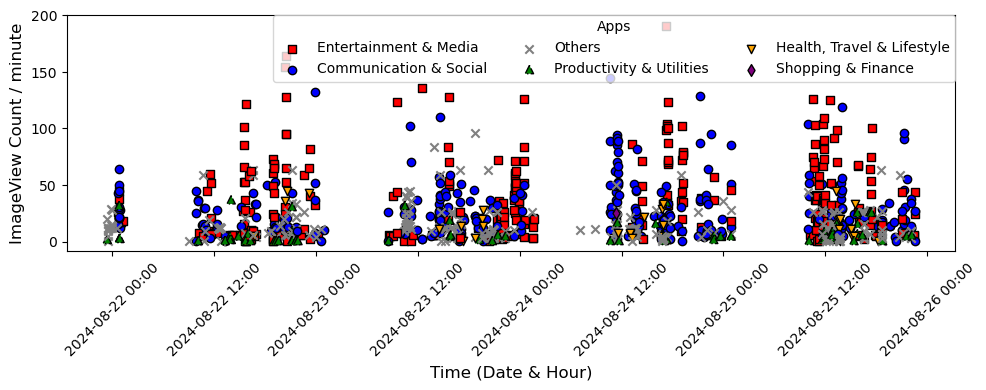

([('com.baidu.netdisk:id',
   [(datetime.datetime(2024, 8, 22, 10, 12, 45), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 45), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 12, 51), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 10, 39, 12), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datetime(2024, 8, 22, 11, 14, 33), 1),
    (datetime.datet

In [5]:
draw_xml_folder(app_imageview_data, folder_path, app_categories, 40)

In [6]:
from collections import defaultdict

def calculate_daily_imageview_counts(app_imageview_data):
    daily_imageview_counts = defaultdict(int)
    
    # 遍历每个 app 的数据
    for app_name, data in app_imageview_data.items():
        # 遍历每个时间戳和 count
        for timestamp, count in data:
            # 提取日期部分
            date = timestamp.date()
            # 累加每天的图片数
            daily_imageview_counts[date] += count
    
    # 打印每天的图片总数
    for date, total_count in sorted(daily_imageview_counts.items()):
        print(f"Date: {date}, Total ImageView Count: {total_count}")

# 调用函数
calculate_daily_imageview_counts(app_imageview_data)

Date: 2024-08-21, Total ImageView Count: 167
Date: 2024-08-22, Total ImageView Count: 5359
Date: 2024-08-23, Total ImageView Count: 15333
Date: 2024-08-24, Total ImageView Count: 7054
Date: 2024-08-25, Total ImageView Count: 6743


Total images: 6158
Total processed images: 5352.673300165209


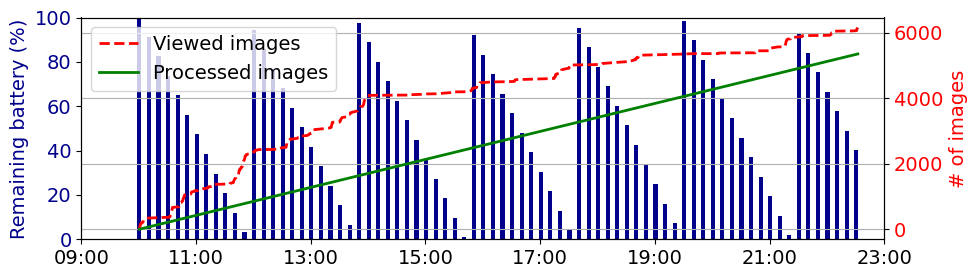

Total images: 6158
Total processed images: 6087.6171096007465


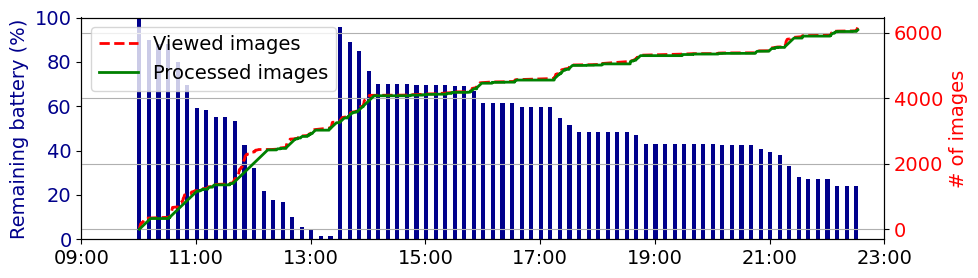

In [9]:
# data of xwk
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from datetime import datetime, time as dt_time, timedelta
import matplotlib.dates as mdates

processing_speed = 0.263314688 * 32  # 每张图片处理时间（秒）
MEM_power = 5.4 # J
ours_power = 5.2 # J
last_processed_time = None

def obtain_cumulative_image_counts_for_day(app_imageview_data, target_day):
    cumulative_image_counts = []
    total_image_count = 0

    # 记录按时间累积图片数量
    timestamp_image_count = defaultdict(int)
    
    for app_data in app_imageview_data.values():
        for time_stamp, count in app_data:
            if time_stamp.date() == target_day and time_stamp.time() >= dt_time(9, 0):  # 仅统计9点后的数据
                timestamp_image_count[time_stamp] += count

    # 按时间顺序遍历目标日期的所有时间点，并记录电量和累计图片数量
    sorted_times = sorted(timestamp_image_count.keys())
    
    for time in sorted_times:
        image_count_at_time = timestamp_image_count[time]
        total_image_count += image_count_at_time
        
        cumulative_image_counts.append(total_image_count)
        
    return sorted_times, cumulative_image_counts

def monitor_image_processing(sorted_times, cumulative_image_counts, processing_rate=0): 
    # 假设我们从sorted_times的第一个时间戳开始监控
    current_time = sorted_times[0]
    last_processed_time = current_time

    # 已处理的图片数量
    processed_image_count = 0
    total_processed_images = []

    # 记录用于绘图的数据
    monitor_times = []
    processed_images_over_time = []

    monitor_interval = timedelta(seconds=1)  # 监控间隔为1秒

    # 初始剩余图片数量
    remaining_images = 0

    processed_images_total = 0
    while current_time <= sorted_times[-1]:
        # 如果还有剩余图片
        if remaining_images > 0:
            elapsed_time_seconds = (current_time - last_processed_time).total_seconds()
            processed_images = min(processing_rate * elapsed_time_seconds, remaining_images)
            remaining_images -= processed_images
            processed_image_count += processed_images
            last_processed_time = current_time
        # print(processed_images)
        # 记录当前时间和已处理图片的数量
        monitor_times.append(current_time)
        processed_images_over_time.append(processed_image_count)
        # print(f"processed_image_count={processed_image_count}")

        # 将监控时间向前推进1秒
        current_time += monitor_interval

        # 检查在此时间内是否有新的图片出现
        for i, time in enumerate(sorted_times):
            if time > last_processed_time and time <= current_time:
                new_images = cumulative_image_counts[i] - cumulative_image_counts[i-1]
                processed_images_total += new_images
                remaining_images += new_images
                # print(f"cumulative_image_counts[i]: {cumulative_image_counts[i]}")
        # print(remaining_images)
        # print(processed_images_total)
    return monitor_times, processed_images_over_time

def calculate_and_plot_battery_consumption(app_imageview_data, target_day, processing_rate, battery_consumption, path):

    sorted_times, cumulative_image_counts = obtain_cumulative_image_counts_for_day(app_imageview_data, target_day)

    monitor_times, processed_images_over_time = monitor_image_processing(sorted_times, cumulative_image_counts, processing_rate)
    battery_percentage = 100
    battery_over_time = []
    interval_minutes = 10 # 每10分钟统计一次

    current_interval_start = monitor_times[0]
    interval_duration = timedelta(minutes=interval_minutes)
    remaining_battery = battery_percentage
    time_intervals = []
    
    for i in range(0, len(monitor_times), interval_minutes * 60):  # 因为监控间隔是1秒，所以这里每600秒（即10分钟）统计一次
        # 统计每个10分钟内的电量消耗
        interval_processed = False
        battery_over_time.append(remaining_battery)
        
        for j in range(i, min(i + interval_minutes * 60, len(monitor_times))):
            # 计算这一秒是否在处理图片（即processed_images_over_time[j]是否大于上一个值）
            if j > 0 and processed_images_over_time[j] > processed_images_over_time[j - 1]:
                interval_processed = True
                remaining_battery -= battery_consumption / 60
            
            # print(remaining_battery, battery_consumption / 60)

            # 如果电量消耗到0以下，重置为100%
            if remaining_battery < 0:
                remaining_battery = 100

        # 记录当前时间段用于绘图
        time_intervals.append(current_interval_start)
        
        # 移动到下一个10分钟的时间段
        current_interval_start += interval_duration

    plt.rcParams.update({'font.size': 14})  # 全局设置字体大小

    fig, ax1 = plt.subplots(figsize=(10, 3))
    # 绘制剩余电量的柱状图
    ax1.bar(time_intervals, battery_over_time, width=0.003, color='darkblue', label='Remaining Battery')
    # ax1.set_xlabel('Time')
    ax1.set_ylabel('Remaining battery (%)', color='darkblue')
    ax1.tick_params(axis='y', labelcolor='darkblue')
    ax1.set_ylim(0,100)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 只显示小时和分钟
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))   # 每小时标记一次

    start_time = sorted_times[0]
    start_time = start_time.replace(hour=9, minute=00, second=0) 
    end_time = start_time.replace(hour=23, minute=00, second=0)  # 限制到23点之前


    ax1.set_xlim(start_time, end_time)

    ax2 = ax1.twinx()

    ax2.plot(sorted_times, cumulative_image_counts, color="red", linestyle='--', linewidth=2, label ="Viewed images")
    ax2.plot(monitor_times, processed_images_over_time, color='green', linestyle='-', linewidth=2, label='Processed images')

    ax2.set_ylabel('# of images', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    print(f"Total images: {cumulative_image_counts[-1]}")
    print(f"Total processed images: {processed_images_over_time[-1]}")

    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(path, bbox_inches='tight')
    plt.show()

# 示例使用:
# 调用函数，假设 monitor_times 和 processed_images_over_time 已经被填充
baseline_pdf = '../figs/trace/battery_consumption_baseline.pdf'
ours_pdf = '../figs/trace/battery_consumption_ours.pdf'
target_day = datetime(2024, 8, 25).date()
processing_rate = 1 / (0.263314688 * 32)  # 每秒处理n张图片 1 / latency
battery_consumption = (44 / 5000) * 100  # 每分钟处理图片消耗1%的电量 44mah / 5000 mah
calculate_and_plot_battery_consumption(app_imageview_data,  target_day, 0.11867928917053043, (44 / 5000) * 100, 
baseline_pdf)
calculate_and_plot_battery_consumption(app_imageview_data,  target_day, 0.47021387, (52 / 5000) * 100, 
ours_pdf)

In [8]:
# 示例使用:
# 调用函数，假设 monitor_times 和 processed_images_over_time 已经被填充
target_day = datetime(2024, 8, 25).date()
processing_rate = 1 / (0.263314688 * 32)  # 每秒处理n张图片 1 / latency
battery_consumption = (44 / 5000) * 100  # 每分钟处理图片消耗1%的电量 44mah / 5000 mah
calculate_and_plot_battery_consumption(app_imageview_data,  target_day, processing_rate, battery_consumption)

TypeError: calculate_and_plot_battery_consumption() missing 1 required positional argument: 'path'